##**About the Project:<br>** 
**Project Title:** 
Code-switching on Reddit <br>
**Author:** Nandini Jirobe <br>
**Last edited:** August 11, 2022 <br>
**Description:**
Hindi-English code-switching is very common these days among people who speak both languages. You can see this happening in everyday conversation and on social media.
The objective of this project is to figure out when people code switch from English to Hindi on Reddit. The following steps are being taken to achieve this goal: <br>
1. Collect data from India and Hindi related subreddits
2. Clean the data
3. Calculate the language distribution of each post (work in progress)
4. Analyze just the Hindi text from all posts (work in progress)<br>
**Note:** This Jupyter Notebook will only run after the "Reddit User Info" section is filled out

## **Install required tools**

In [ ]:
#@title
!pip install praw # package for social network scraping
!pip install pandas # to display the data collected from posts
!pip install clean-text # used for emoji removal
!pip install Unidecode # used for emoji removal
!pip install spacy # used for tokenization of words and POS tagging of English words
!pip install googletrans==3.1.0a0 # used for translating and detecting Hindi words
!pip install codeswitch # NLP tool can use for language identification

In [ ]:
#@title
# Pyenchant is apparently no longer maintained.
# This is one of the ways to install it without having issues
!apt update
!apt install enchant --fix-missing
!apt install -qq enchant
!pip install pyenchant

##**Import libraries**

In [ ]:
#@title
import praw # reddit scrapping tool
import pandas as pd # used for data anaylsis, lets us use dataframes
import json # used to convert dictionary to json file
import re # regular expressions
from cleantext import clean # used for emoji removal
import matplotlib.pyplot as plt # used for data visualization
import numpy as np # used for data visualization
from operator import itemgetter # this is use for sorting a dictionary
import random #just for choosing random colors for bar charts 
import nltk # used for english stop word removal
from nltk.corpus import stopwords # used for english stop word removal
nltk.download('stopwords')
import spacy # used for tokenization of words and POS tagging of English words
from spacy.tokens.token import Token # used for tokenization of words and POS tagging of English words
import enchant # this is used for identifying english words
from codeswitch.codeswitch import LanguageIdentification # to detect hindi, english
from googletrans import Translator # used for translating and detecting Hindi words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **Reddit User Info**

In [ ]:
#@title
"""
This dictionary contains info about the user's Reddit app.
Information is unique and confidential to each user. 
Instructions to create own app is here:
https://www.geeksforgeeks.org/scraping-reddit-using-python/
"""
userInfo = {
  "client_id" : "__",
  "client_secret" : "__",
  "user_agent" : "__" 
}

In [ ]:
#@title
"""
There are two instances of PRAW. The one below allows you
to access only publicly available information from Reddit
""" 
reddit_read_only = praw.Reddit(client_id = userInfo ["client_id"],
                               client_secret= userInfo["client_secret"],
                               user_agent= userInfo["user_agent"],
                               check_for_async=False)

##**Data Collection Functions**

In [ ]:
#@title
"""
The devangari alphabet ranges from 0900 to 097F. The code 
below creates a string containing all the alphabets' unicodes.
This was created to check if a text contained any devangari 
alphabets.
"""
devanagariAlphabet = ""
uniList = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
           "A", "B", "C", "D", "E", "F"]
for i in range (90, 97):
  for j in uniList:
    devanagariAlphabet += ("\\u0" + str(i) + str(j))
devanagariAlphabet = "[" + devanagariAlphabet + "]"

# checks if text contains and devangari alphabets
def hasDevanagariAlpha(text):
  pattern = re.compile(devanagariAlphabet)
  # finditer returns regex match objects while 
  # findall returns a tuple of the matches found
  matches = pattern.findall(text) 
  if (len(matches) > 0):
    return True
  return False

In [ ]:
#@title
"""
Data collection function:
Given a subreddit name and specified limit, this funciton collects 
reddit posts. Only those posts which are i) not pinned, ii) have text, 
iii) and do not contain Devanagari characters are saved.
Info such as post ID, Title, Content are stored in a dictionary.
All these dictionaries are then put into a list.
"""
def collect_redditPosts (subreddit, limit, allRedditPosts):
  postCount = 0
  subreddit = reddit_read_only.subreddit(subreddit)
  all_posts = subreddit.hot(limit = limit) # this can be changed to new/top.
  for post in all_posts:
    redditPost = {}
    if hasDevanagariAlpha(post.selftext) == False and post.stickied == False and len(post.selftext) >=50 and len(post.selftext) <= 2000:
      postCount+=1
      redditPost['ID'] = post.id
      redditPost['Title'] = post.title
      redditPost['Content'] = post.selftext
      allRedditPosts.append(redditPost)
  print("Total posts collected:", postCount)

## **Data Cleaning Functions**

In [ ]:
#@title
"""
Data Cleaning functions
"""
# modified text cleaning function from Twitter-Scrape-SNSCRAPE.ipynb file
# Used regular expressions to clean text
# Returns cleaned text
def clean_text(text):
  text = re.sub(r"http\S+", "", text) # remove urls
  text = re.sub(r'\S+\.com\S+','',text) # remove urls
  text = re.sub(r'u/\w+','',text) # remove user mentions
  text = re.sub(r'u/\w+','',text) # remove subreddit mentions
  text = re.sub(r'\n',' ',text) # remove new lines
  text = clean(text, no_emoji = True) # remove emojis
  text = text.strip() # remove leading/trailing spaces
  text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # remove symbols
  text = text.lower()
  return text

## **Language Identification functions (work in progress)** 

In [ ]:
# These maps keep track the number of occurances of each word
# from all the posts. 
hinMap = {}
engMap = {}
othMap = {}

# This function adds values to the hinMap, engMap, 
# othMap. It also makes sure no stop words are added
engStopWords = set(stopwords.words('english'))
def addToMap(word, theMap):
  if word not in engStopWords:
    if word in theMap:
      theMap[word]+=1
    else:
      theMap[word]=1

"""
Calculating Language Distribution using Google Translate and PyEnchant
This function (calcLangDist1) is currently not in use. Slow compared to calcLangDist2()
It counts all Hindi, English and Other words and returns the percentage
of each language present in the text.
"""
def calcLangDist1(text):
  engDict = enchant.Dict("en_US")
  translator = Translator()
  nlp = spacy.load("en_core_web_sm")
  text = clean_text(text)
  tokens = nlp(text)

  hinCount = 0
  engCount = 0
  othCount = 0 
  total = len(tokens)
  
  for token in tokens:
    hinToEng = translator.translate(str(token), src='hi', dest='en') # translate using Googletrans
    if (str(token) != hinToEng.text and len(hinToEng.text) > 0 and engDict.check(hinToEng.text)): # English check using PyEnchant
      hinCount+=1
      addToMap(str(token), hinMap)
    elif engDict.check(str(token)):
      engCount+=1
      addToMap(str(token), engMap)
    else:
      othCount+=1
      addToMap(str(token), othMap)

  if total == 0:
    return 0, 0, 0
  else:
    return (hinCount/total), (engCount/total), (othCount/total)

In [ ]:
"""
Calculating Language Distribution using Codeswitch
calcLangDist2 that uses this tool is currently in use.
Completes task quicker than calcLangDist1
"""

# These lists keep track of the words from each category
# They are emptied once a text's language distribution has been calculated
hinList = []
engList = []
othList = []

def addToList(theList, word, prevList):
  # A word is catergorized based on what its entity is
  # If a word contains a hashtag it is added to whatever list 
  # the previous list was added to
  if '#' in word:
    word = word.replace('#', '')
    if(prevList == "hi"):
      hinList[len(hinList)-1] = hinList[len(hinList)-1] + word
    elif(prevList == "en"):
      engList[len(engList)-1] = engList[len(engList)-1] + word
    else:
      othList[len(othList)-1] = othList[len(othList)-1] + word
  else:
    theList.append(word)
    if (theList == hinList):
      prevList = "hi"
    elif (theList == engList):
      prevList = "en"
    else:
      prevList = "ot"
  return prevList

lid = LanguageIdentification('hin-eng') # downloads hin-eng model required to classify words
def calcLangDist2(sentence):
  # All percent values are set to 0
  engPct = 0
  hinPct = 0
  othPct = 0
  prevList = ""

  # tokenenize and label data
  result = lid.identify(sentence)

  # A word is catergorized based on what its entity is
  # If a word contains a hashtag it is added to whatever list 
  # the previous list was added to
  for item in result:
    if (item['entity'] == 'hin'):
      prevList = addToList(hinList, item['word'], prevList)
    elif(item['entity'] == 'en'):
      prevList = addToList(engList, item['word'], prevList)
    else:
      prevList = addToList(othList, item['word'], prevList)

  # add words from list to their maps
  for word in hinList:
    addToMap(word, hinMap)
  for word in engList:
    addToMap(word, engMap)
  for word in othList:
    addToMap(word, othMap)

  # calculate the total percetange of each language in the text
  totalCount = len(hinList) + len(engList) + len(othList)
  if totalCount != 0:
    engPct = (len(engList)/totalCount)*100
    hinPct = (len(hinList)/totalCount)*100
    othPct = (len(othList)/totalCount)*100

  hinList.clear()
  engList.clear()
  othList.clear()
  return engPct, hinPct, othPct

Model Download Completed!


In [ ]:
#@title
"""
This calculates the average language
distribution of all posts.
"""
def avgLangDist(allPosts):
  hinPctList = [];
  engPctList = [];
  othPctList = [];
  engAvg = 0
  hinAvg = 0
  othAvg = 0
  postsAnalyzed = 1
  for post in allPosts:
    engPct, hinPct, othPct = calcLangDist2(post['Content'])
    print("Posts Analyzed:", postsAnalyzed)
    postsAnalyzed+=1
    post['ENG-PCT'] = round (engPct,2)
    post['HIN-PCT'] = round (hinPct,2)
    post['OTH-PCT'] = round (othPct,2)
    engPctList.append(engPct)
    hinPctList.append(hinPct)
    othPctList.append(othPct)

  if (len(engPctList) != 0):
    engAvg = sum(engPctList)/len(engPctList)
  if (len(hinPctList) != 0):
    hinAvg = sum(hinPctList)/len(hinPctList)
  if (len(othPctList) != 0):
    othAvg = sum(othPctList)/len(othPctList)
  return engAvg, hinAvg, othAvg

##**Remove English Words function (work in progress)** 

In [ ]:
"""
Takes in a sentence, removes all English words, and returns 
a list of the remaining words
"""
# Global variables
commonHindiWords = {}

def addToMap1(word, theMap):
  if word in theMap:
    theMap[word]+=1
  else:
    theMap[word]=1

def remove_eng_words(text):
  hinWords = []
  nlp = spacy.load("en_core_web_sm")
  engDict = enchant.Dict("en_US")
  text = clean_text(text)
  tokens = nlp(text)
  for token in tokens:
    if engDict.check(str(token)) == False:
      hinWords.append(str(token))
      addToMap1(str(token), commonHindiWords)
  return hinWords

##**Data Visualization functions**

In [ ]:
#@title
"""
Data Visualization
"""
def makeAndDisplayPieChart(topic, englishPercentage, hindiPercentage, otherPercentage):
  data = np.array([englishPercentage, hindiPercentage, otherPercentage])
  theLabels = ["English", "Hindi", "Other"]
  plt.pie (data, labels = theLabels, autopct='%1.2f%%')
  plt.title(topic)
  plt.tight_layout()
  plt.show()

def makeAndDisplayDF(posts):
  theDF = pd.DataFrame (posts, columns=['Text', 'ENG-PCT', 'HIN-PCT', 'OTH-PCT'])
  json_dict = json.dumps(posts, indent=2) # indent is for spacing format of data in the file
  pd.set_option('expand_frame_repr', False) # ensures that datafram is all in one line instead of multiple
  print(theDF)
  with open("FileValues.json", "w") as f:
    f.write(json_dict)

def makeAndDisplayBarChart(dictionary, lang, col):
  red = random.randint(0, 255)
  blue = random.randint(0, 255)
  green = random.randint(0, 255)
  dictionary = dict(sorted(dictionary.items(), key = itemgetter(1), reverse = True)) # learned how to do this from GeeksForGeeks: https://www.geeksforgeeks.org/python-n-largest-values-in-dictionary/
  dictionary = dict(list(dictionary.items())[:5])
  print(dictionary)
  plt.bar(dictionary.keys(), dictionary.values(), color = col)
  plt.title(('Most Common '+ lang + ' Words Used'))
  plt.xlabel('Words')
  plt.ylabel('No. of Occurances')
  plt.show()

##**Main ()**

In [ ]:
#@title
"""
The entire process
"""
def main():
  # this is a list of reddit posts
  redditPosts = [] 

  # 1) Collect posts
  print("collecting reddit posts...")
  collect_redditPosts ("india", 500, redditPosts)
  collect_redditPosts ("IndiaSpeaks", 500, redditPosts)
  collect_redditPosts ("bollywood", 500, redditPosts)
  collect_redditPosts ("mumbai", 500, redditPosts)

  # 2) Clean posts
  print("cleaning reddit posts...")
  for post in redditPosts:
    post['Content'] = clean_text(post['Content'])

  # 3) Calculate language distribution (work in progress)
  # Currenlty using codeswitch method (calcLangDist2)
  print("calculating language distribution of all reddit posts...")
  engAvg, hinAvg, othAvg = avgLangDist(redditPosts)

  # 4) Analyze just the Hindi text from all posts. (work in progress)
  # use remove_eng_words function
  # find patterns in Hindi words used

  # 5) Displaying Data
  print("building pie charts...")
  makeAndDisplayPieChart("Average language distribution of all Reddit Posts", engAvg, hinAvg, othAvg)  
  makeAndDisplayDF(redditPosts)

  # putting all cleanded texts in a json file
  count = 1
  with open('posts.txt', 'w') as f:
      for post in redditPosts:
          f.write(post["Content"])
          f.write('\nPOST #:'+ str(count) +'\n')
          count+=1


collecting reddit posts...
Total posts collected: 249
Total posts collected: 70
Total posts collected: 278
Total posts collected: 362
cleaning reddit posts...
calculating language distribution of all reddit posts...
Posts Analyzed: 1
Posts Analyzed: 2
Posts Analyzed: 3
Posts Analyzed: 4
Posts Analyzed: 5
Posts Analyzed: 6
Posts Analyzed: 7
Posts Analyzed: 8
Posts Analyzed: 9
Posts Analyzed: 10
Posts Analyzed: 11
Posts Analyzed: 12
Posts Analyzed: 13
Posts Analyzed: 14
Posts Analyzed: 15
Posts Analyzed: 16
Posts Analyzed: 17
Posts Analyzed: 18
Posts Analyzed: 19
Posts Analyzed: 20
Posts Analyzed: 21
Posts Analyzed: 22
Posts Analyzed: 23
Posts Analyzed: 24
Posts Analyzed: 25
Posts Analyzed: 26
Posts Analyzed: 27
Posts Analyzed: 28
Posts Analyzed: 29
Posts Analyzed: 30
Posts Analyzed: 31
Posts Analyzed: 32
Posts Analyzed: 33
Posts Analyzed: 34
Posts Analyzed: 35
Posts Analyzed: 36
Posts Analyzed: 37
Posts Analyzed: 38
Posts Analyzed: 39
Posts Analyzed: 40
Posts Analyzed: 41
Posts Analyzed

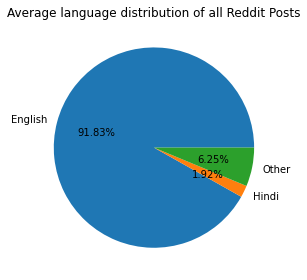

     Text  ENG-PCT  HIN-PCT  OTH-PCT
0     NaN    94.39     0.00     5.61
1     NaN    96.67     0.00     3.33
2     NaN    98.03     0.00     1.97
3     NaN   100.00     0.00     0.00
4     NaN    88.39     0.00    11.61
..    ...      ...      ...      ...
954   NaN    71.79     0.00    28.21
955   NaN   100.00     0.00     0.00
956   NaN    96.00     4.00     0.00
957   NaN    92.82     3.59     3.59
958   NaN    92.59     0.00     7.41

[959 rows x 4 columns]


In [ ]:
#@title
main()

##**Displaying the Results**

{'hai': 61, 'ke': 26, 'ki': 18, 'se': 17, 'nahi': 16}


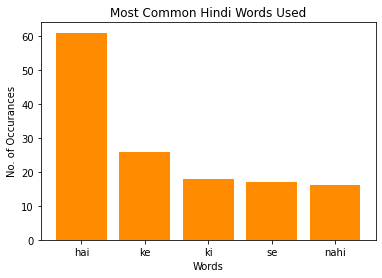

{'like': 338, 'know': 232, 'dont': 222, 'would': 220, 'im': 214}


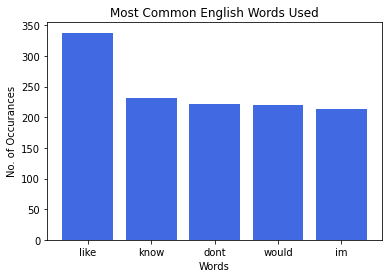

{'india': 140, 'mumbai': 114, '2': 99, 'bollywood': 90, '3': 71}


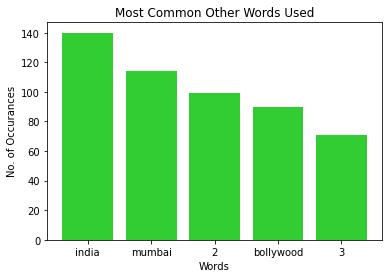

In [ ]:
#@title
makeAndDisplayBarChart(hinMap, "Hindi", "darkorange")
makeAndDisplayBarChart(engMap, "English", "royalblue")
makeAndDisplayBarChart(othMap, "Other", "limegreen")